In [30]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil

from eos import cms_eos,cd_eos, mls_eos, scvh_eos, aqua_eos, mixtures_eos, mh13_eos

%matplotlib inline

In [31]:
test = 1.0*(u.erg/(u.g * u.K))
print(test.to(u.MJ/(u.kg * u.K)))
mJtoGrams = u.jupiterMass.to(u.g)

rJtorSun = u.jupiterRad.to(u.solRad)
rJtoCm = u.jupiterRad.to(u.cm)

1e-10 MJ / (K kg)


In [32]:
log10rho = np.round(np.linspace(-8.,6.0, 14*20),2)
log10T= np.round(np.linspace(2.,8.0,6*20),2)
z0 = 0.

y_const = 0.
f_H = 1.
Z = f_H + 2*(1.-f_H)
A = f_H + 4*(1.-f_H)

# Units 

# CMS19, CD21 paper units are:
    - log10(T [K])
    - log10(P [GPa])
    - log10(rho [g cm^-3])
    - log10(U [MJ/kg])
    - log10(S [MJ/kg/K])
# EoS module units are:
    - T [log10 K]
    - P [log10 dyn cm^-2]
    - rho [log10 g cm^-3]
    - U [log10 erg g^-1]
    - S input: [kb/baryon ~= 1.203e-8 erg g^-1 K^-1], output: [erg g^-1 K^-1]

In [45]:
log10Tgrid, log10rhogrid = np.meshgrid(log10T, log10rho)
log10Sgrid = np.zeros_like(log10Tgrid)
log10Pgrid = np.zeros_like(log10Tgrid)

col5grid = np.zeros_like(log10Tgrid) # = dlrho/dlT_P          EoS quantity 4 given at each grid point
col6grid = np.zeros_like(log10Tgrid) # = dlrho/dlP_T          EoS quantity 3 given at each grid point
col7grid = np.zeros_like(log10Tgrid) # = dlS/dlT_P            EoS quantity 6 given at each grid point
col8grid = np.zeros_like(log10Tgrid) # = dlS/dlP_T            EoS quantity 5 given at each grid point
col9grid = np.zeros_like(log10Tgrid) # = grad_ad              EoS quantity 7 given at each grid point

for i in range(len(log10T)):
    for j in range(len(log10rho)):
        s_cms = cms_eos.get_s_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const, z=z0) # erg g^-1 K^-1
        #s_cms = mh13_eos.get_s_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const) # erg g^-1 K^-1
        #s_cms = cd_eos.get_s_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const, z=z0) # erg g^-1 K^-1
        #s_cms = mixtures_eos.get_s_rhot_tab(_lgrho=log10rho[j], _lgt=log10T[i], _y=y_const, _z=z0, hhe_eos='cms') # erg g^-1 K^-1
        # convert to MJ/kg/K
        s_cms_ = s_cms * 1.e-10
        log10Sgrid[j,i] = np.log10(s_cms_)
        
        p_cms = cms_eos.get_p_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const, z=z0) # log10 dyn cm^-2 
        #p_cms = mh13_eos.get_p_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const) # log10 dyn cm^-2 
        #p_cms = cd_eos.get_p_rhot_tab(rho=log10rho[j], t=log10T[i], y=y_const, z=z0) # log10 dyn cm^-2 
        #p_cms = mixtures_eos.get_p_rhot_tab(_lgrho=log10rho[j], _lgt=log10T[i], _y=y_const, _z=z0, hhe_eos='cms') # log10 dyn cm^-2 
        # convert to Gpa
        p_cms_ = 10**p_cms
        p_cms_ = p_cms_ * 1.e-10
        p_cms_ = np.log10(p_cms_)
        log10Pgrid[j,i] = p_cms_
"""
        # derivatives from table
        #col5 = cms_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, z=z0, dt=1.e-2) #drho/dT_{P,Y}
        col5 = mh13_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, dt=1.e-2) #drho/dT_{P,Y}
        #col5 = cd_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, z=z0, dt=1.e-2) #drho/dT_{P,Y}
        #col5 = mixtures_eos.get_drhodt_py(_lgp=p_cms, _lgt=log10T[i], _y=y_const, _z=z0, dt=1.e-2, hhe_eos='cms') #drho/dT_{P,Y}
        #convert drho to dlogrho, dT to dlogT
        try:
            col5_ = col5[0] * (log10rho[j]/log10T[i]) #rho, T units are the same in the CMS tables and the eos module, so no unit conversion necessary
        except IndexError:
            col5_ = col5 * (log10rho[j]/log10T[i])
        col5grid[j,i] = col5_

        '''
        col6 = 
        #
        col6_ =
        col6grid[j,i] = col6_
        '''
        try:
            #col7 = cms_eos.get_c_p(s=s_cms, p=p_cms, y=y_const, z=z0, ds=1.e-2) #ds/dlogT_{P,Y}
            col7 = mh13_eos.get_c_p(s=s_cms, p=p_cms, y=y_const,  ds=1.e-2) #ds/dlogT_{P,Y}
            #col7 = cd_eos.get_c_p(s=s_cms, p=p_cms, y=y_const, z=z0, ds=1.e-2) #ds/dlogT_{P,Y}
            #col7 = mixtures_eos.get_c_p(_s=s_cms, _lgp=p_cms, _y=y_const, _z=z0, ds=1.e-2, hhe_eos='cms') #ds/dlogT_{P,Y}
        except ZeroDivisionError:
            col7 = np.nan
        # convert ds to dlogs 
        col7_ = col7/(s_cms * np.log(10))
        # no S unit conversion necessary because dlog10(S) is unitless
        col7grid[j,i] = col7_
        
        '''
        col8 = 
        col8_ = 
        col8grid[j,i] = col8_
        '''
        #col9 = cms_eos.get_nabla_ad(s=s_cms, p=p_cms, y=y_const, z=z0, dp=1.e-2) #dlogT/dlogP
        col9 = mh13_eos.get_nabla_ad(s=s_cms, p=p_cms, y=y_const, dp=1.e-2) #dlogT/dlogP
        #col9 = cd_eos.get_nabla_ad(s=s_cms, p=p_cms, y=y_const, z=z0, dp=1.e-2) #dlogT/dlogP
        #col9 = mixtures_eos.get_nabla_ad(_s=s_cms, _lgp=p_cms, _y=y_const, _z=z0, dp=1.e-2, hhe_eos='cms') #dlogT/dlogP
        # no P unit conversion necessary because dlog10(P) is unitless
        col9grid[j,i] = col9
   """     
    

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_62214/2052893240.py:19: RuntimeWarning: invalid value encountered in log10
  log10Sgrid[j,i] = np.log10(s_cms_)


"\n        # derivatives from table\n        #col5 = cms_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, z=z0, dt=1.e-2) #drho/dT_{P,Y}\n        col5 = mh13_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, dt=1.e-2) #drho/dT_{P,Y}\n        #col5 = cd_eos.get_drhodt_py(p=p_cms, t=log10T[i], y=y_const, z=z0, dt=1.e-2) #drho/dT_{P,Y}\n        #col5 = mixtures_eos.get_drhodt_py(_lgp=p_cms, _lgt=log10T[i], _y=y_const, _z=z0, dt=1.e-2, hhe_eos='cms') #drho/dT_{P,Y}\n        #convert drho to dlogrho, dT to dlogT\n        try:\n            col5_ = col5[0] * (log10rho[j]/log10T[i]) #rho, T units are the same in the CMS tables and the eos module, so no unit conversion necessary\n        except IndexError:\n            col5_ = col5 * (log10rho[j]/log10T[i])\n        col5grid[j,i] = col5_\n\n        '''\n        col6 = \n        #\n        col6_ =\n        col6grid[j,i] = col6_\n        '''\n        try:\n            #col7 = cms_eos.get_c_p(s=s_cms, p=p_cms, y=y_const, z=z0, ds=1.e-2) #ds/dlo

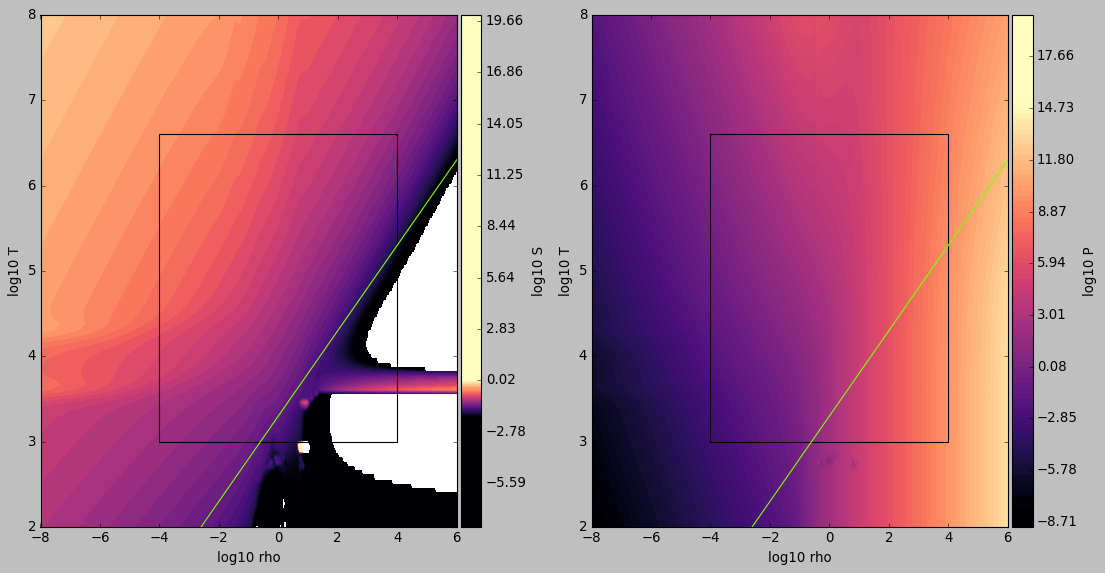

In [47]:
# make plots of S, P across grid first, just to make sure everything looks continuous

fig, axes = plt.subplots(1,2,figsize=(16,8))


divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cs0 = axes[0].contourf(log10rhogrid, log10Tgrid, log10Sgrid, levels=np.linspace(-8,20,500), cmap='magma',alpha=1,vmin=-2, vmax=0)
fig.colorbar(cs0, cax=cax0, orientation='vertical',label='log10 S')
axes[0].set_ylabel('log10 T')
axes[0].set_xlabel('log10 rho')

divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cs1 = axes[1].contourf(log10rhogrid, log10Tgrid, log10Pgrid, levels=np.linspace(-9,20,100), cmap='magma',alpha=1,vmin=-8, vmax=15)
fig.colorbar(cs1, cax=cax1, orientation='vertical',label='log10 P')
axes[1].set_ylabel('log10 T')
axes[1].set_xlabel('log10 rho')

log10rho_ = np.linspace(-8,8,100)

for ax in axes:
    p = plt.Rectangle((-4,3),8,3.6,fill=False,color='k')
    #p = plt.Rectangle((-5,2.1),6.5,2.9,fill=False,color='k')
    ax.add_patch(p)
    ax.set_xlim(-8,6)
    ax.set_ylim(2,8)

    # chabrier+2019 eq 3, limit of validity of EoS
    ax.plot(log10rho_, 3.3 + (1./2.)*log10rho_ + np.log10(Z) - (5./3)*np.log10(A), ls='-', color='#7FFF00')

plt.subplots_adjust(hspace=0.1,wspace=0.25)
plt.show()


#ignore everything below the green line!!

In [38]:
print(np.max(log10Sgrid))

nan


In [39]:
# we want to calculate, from grid dimensions T [:,0] and rho [:,2] and tabulated S  [:,4] and P [:,1] only,
# the four finite difference quantities from Sunny's notes
# dlnP_dlnrho_T
# dlnP_dlnT_rho
# dlnS_dlnrho_T
# dlnS_dlnT_rho

# log10T is constant along each column of log10Sgrid, log10Pgrid (along each column, log10rho takes 281 values)
# log10rho is constant along each row of log10Sgrid, log10Pgrid (along each row, log10T takes 121 values)

In [40]:
# calculate the four finite difference quantities from Sunny's notes
dlnP_dlnrho_T = np.zeros_like(log10Tgrid)
dlnS_dlnrho_T = np.zeros_like(log10Tgrid)

for i in range(len(log10rho) - 1):
    dlnP_dlnrho_T[i] = (log10Pgrid[i+1] - log10Pgrid[i])/(log10rhogrid[i+1] - log10rhogrid[i])
    dlnS_dlnrho_T[i] = (log10Sgrid[i+1] - log10Sgrid[i])/(log10rhogrid[i+1] - log10rhogrid[i])

# fudge last row
dlnP_dlnrho_T[-1] = dlnP_dlnrho_T[-2]
dlnS_dlnrho_T[-1] = dlnS_dlnrho_T[-2]



dlnP_dlnT_rho = np.zeros_like(log10Tgrid)
dlnS_dlnT_rho = np.zeros_like(log10Tgrid)

for j in range(len(log10T) - 1):
    dlnP_dlnT_rho[:,j] = (log10Pgrid[:,j+1] - log10Pgrid[:,j])/(log10Tgrid[:,j+1] - log10Tgrid[:,j])
    dlnS_dlnT_rho[:,j] = (log10Sgrid[:,j+1] - log10Sgrid[:,j])/(log10Tgrid[:,j+1] - log10Tgrid[:,j])

# fudge last column
dlnP_dlnT_rho[:,-1] = dlnP_dlnT_rho[:,-2]
dlnS_dlnT_rho[:,-1] = dlnS_dlnT_rho[:,-2]


In [41]:
# convert these into the tabulated Chabrier quantities for comparison
fd1 = dlnP_dlnrho_T
fd2 = dlnP_dlnT_rho
fd3 = dlnS_dlnrho_T
fd4 = dlnS_dlnT_rho

c3 = 1./fd1
c4 = -fd2/fd1
c6 = fd4 - ((fd2/fd1)*fd3)
c5 = fd3/fd1
c7 = -c5/c6

In [42]:
# plot relative differences to reproduce sunny's figure 1
diff00 = np.abs(c4 - col5grid)/np.abs(col5grid)
#diff01 = np.abs(c3 - col6grid)/np.abs(col6grid)
diff10 = np.abs(c6 - col7grid)/np.abs(col7grid)
#diff11 = np.abs(c5 - col8grid)/np.abs(col8grid)

diffad = np.abs(c7 - col9grid)/np.abs(col9grid)

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_62214/2493391636.py:9: SyntaxWarning: invalid escape sequence '\l'
  '''
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_62214/2493391636.py:19: SyntaxWarning: invalid escape sequence '\l'
  '''


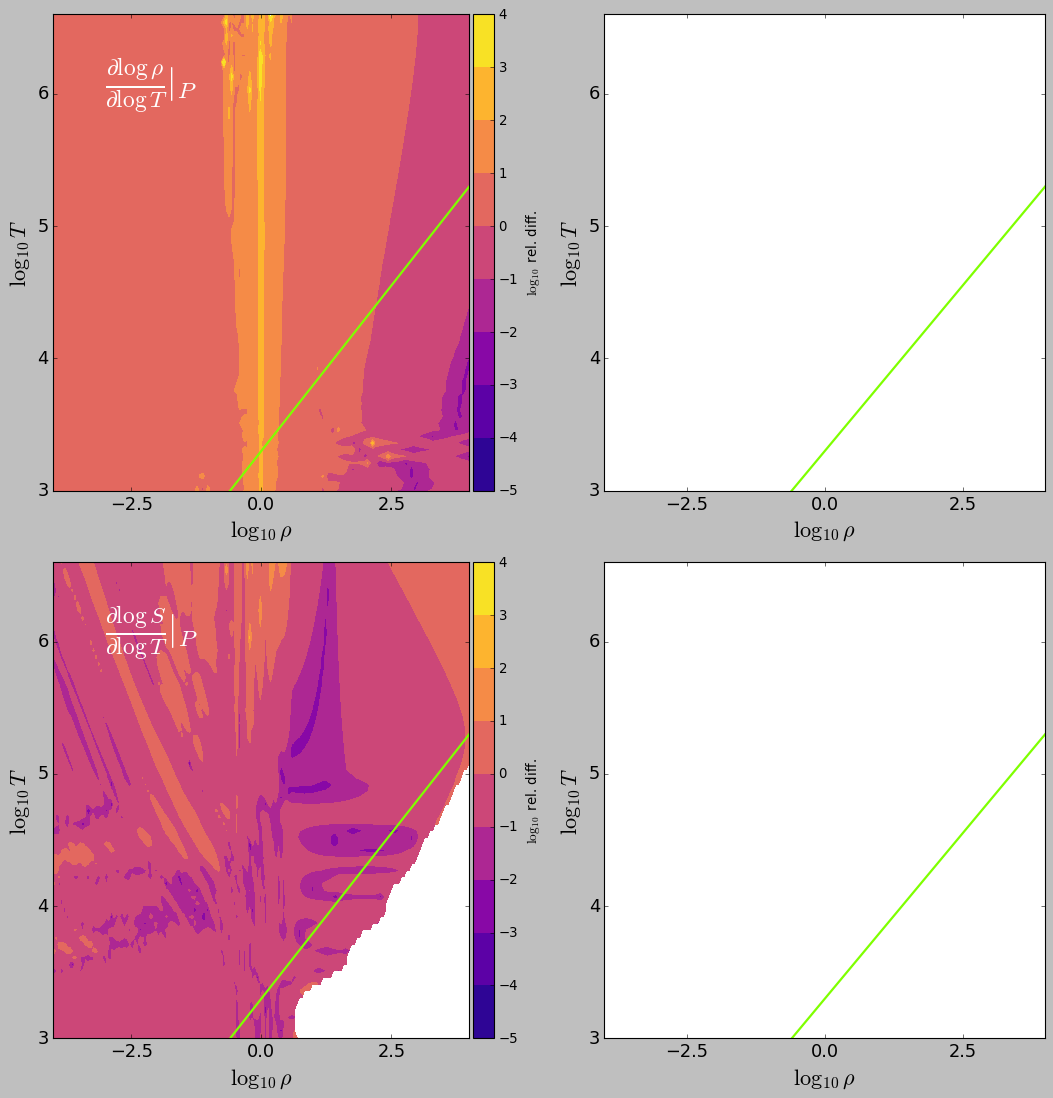

In [43]:
lev = np.arange(-5,5)

fig, axes = plt.subplots(2,2,figsize=(16,16))

divider00 = make_axes_locatable(axes[0,0])
cax00 = divider00.append_axes('right', size='5%', pad=0.05)
cs00 = axes[0,0].contourf(log10rhogrid, log10Tgrid, np.log10(diff00),cmap='plasma',levels=lev)
cbar00 = fig.colorbar(cs00, cax=cax00, orientation='vertical',label=r'$\log_{10}$ rel. diff.',ticks=lev)
'''
divider01 = make_axes_locatable(axes[0,1])
cax01 = divider01.append_axes('right', size='5%', pad=0.05)
cs01 = axes[0,1].contourf(log10rhogrid, log10Tgrid, np.log10(diff01),cmap='plasma',levels=lev)
cbar01 = fig.colorbar(cs01, cax=cax01, orientation='vertical',label=r'$\log_{10}$ rel. diff.',ticks=lev)
'''
divider10 = make_axes_locatable(axes[1,0])
cax10 = divider10.append_axes('right', size='5%', pad=0.05)
cs10 = axes[1,0].contourf(log10rhogrid, log10Tgrid, np.log10(diff10),cmap='plasma',levels=lev)
cbar10 = fig.colorbar(cs10, cax=cax10, orientation='vertical',label=r'$\log_{10}$ rel. diff.',ticks=lev)
'''
divider11 = make_axes_locatable(axes[1,1])
cax11 = divider11.append_axes('right', size='5%', pad=0.05)
cs11 = axes[1,1].contourf(log10rhogrid, log10Tgrid, np.log10(diff11),cmap='plasma',levels=lev)
cbar11 = fig.colorbar(cs11, cax=cax11, orientation='vertical',label=r'$\log_{10}$ rel. diff.',ticks=lev)
'''
for ax in np.ravel(axes):
    #p = plt.Rectangle((-4,3),8,3.6,fill=False,color='b')
    #ax.add_patch(p)
    #ax.set_xlim(-5,1.5)
    #ax.set_ylim(2.1,5.0)
    ax.set_xlim(-4.,4)
    ax.set_ylim(3.,6.6)
    ax.set_ylabel(r'$\log_{10} T$',fontsize=20)
    ax.set_xlabel(r'$\log_{10} \rho$',fontsize=20)
    ax.set_xticks((-2.5,0.,2.5))
    ax.set_yticks((3,4,5,6))
    ax.tick_params(axis='both', which='major', labelsize=16)

    # chabrier+2019 eq 3, limit of validity of EoS
    ax.plot(log10rho_, 3.3 + (1./2.)*log10rho_ + np.log10(Z) - (5./3)*np.log10(A), ls='-', color='#7FFF00',lw=2)

axes[0,0].text(-3,6,r"$\frac{\partial \log \rho}{\partial \log T}|_{P}$",fontsize=30,color='#FFFFFF')
axes[0,1].text(-3,6,r"$\frac{\partial \log \rho}{\partial \log P}|_{T}$",fontsize=30,color='#FFFFFF')
axes[1,0].text(-3,6,r"$\frac{\partial \log S}{\partial \log T}|_{P}$",fontsize=30,color='#FFFFFF')
axes[1,1].text(-3,6,r"$\frac{\partial \log S}{\partial \log P}|_{T}$",fontsize=30,color='#FFFFFF')
plt.subplots_adjust(hspace=0.15,wspace=0.25)
plt.show()
#plt.savefig("./sunnyfig1_He.pdf",bbox_inches='tight')

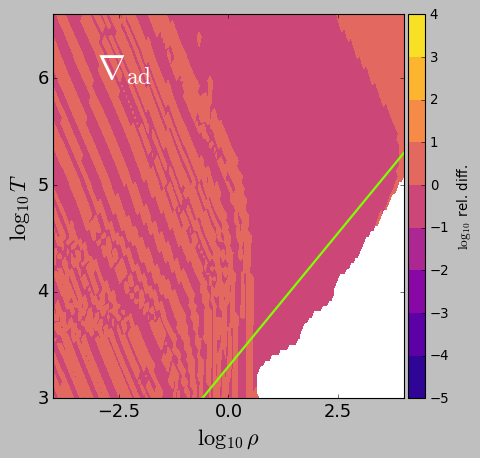

In [44]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cs = ax.contourf(log10rhogrid, log10Tgrid, np.log10(diffad),cmap='plasma',levels=lev)
cbar = fig.colorbar(cs, cax=cax, orientation='vertical',label=r'$\log_{10}$ rel. diff.',ticks=lev)

#ax.set_xlim(-5,1.5)
#ax.set_ylim(2.1,5.0)
ax.set_xlim(-4.,4)
ax.set_ylim(3.,6.6)
ax.set_ylabel(r'$\log_{10} T$',fontsize=20)
ax.set_xlabel(r'$\log_{10} \rho$',fontsize=20)
ax.set_xticks((-2.5,0.,2.5))
ax.set_yticks((3,4,5,6))
ax.tick_params(axis='both', which='major', labelsize=16)

# chabrier+2019 eq 3, limit of validity of EoS
ax.plot(log10rho_, 3.3 + (1./2.)*log10rho_ + np.log10(Z) - (5./3)*np.log10(A), ls='-', color='#7FFF00',lw=2)

ax.text(-3,6,r"$\nabla_{\mathrm{ad}}$",fontsize=30,color='#FFFFFF')
plt.show()
#plt.savefig("./sunnyfig2_He.pdf",bbox_inches='tight')